In [18]:
data_path = '/home/hadoop/data/Mall_Customers.csv'

In [2]:
try:
    sc.stop()
except:
    print('no sc to stop')

In [5]:
# some imports may repeat for modularity inside ipynb cells

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession 

from pyspark.sql.types import StructField, StringType, IntegerType, StructType
from pyspark.mllib.stat import Statistics 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
conf = SparkConf().setAppName('hw38').setMaster('local[4]')
sc = SparkContext.getOrCreate(conf = conf)

spark = SparkSession.builder.appName('hw38').getOrCreate()
sc

<SparkContext master=local[4] appName=hw38>

In [6]:
''

''

In [14]:
df = spark.read.csv('file://{}'.format(data_path), header=True, inferSchema=True)

In [15]:
df.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Annual Income (k$): integer (nullable = true)
 |-- Spending Score (1-100): integer (nullable = true)



In [16]:
df.take(5)

[Row(CustomerID=1, Gender='Male', Age=19, Annual Income (k$)=15, Spending Score (1-100)=39),
 Row(CustomerID=2, Gender='Male', Age=21, Annual Income (k$)=15, Spending Score (1-100)=81),
 Row(CustomerID=3, Gender='Female', Age=20, Annual Income (k$)=16, Spending Score (1-100)=6),
 Row(CustomerID=4, Gender='Female', Age=23, Annual Income (k$)=16, Spending Score (1-100)=77),
 Row(CustomerID=5, Gender='Female', Age=31, Annual Income (k$)=17, Spending Score (1-100)=40)]

In [17]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
CustomerID,200,100.5,57.879184513951124,1,200
Gender,200,None,None,Female,Male
Age,200,38.85,13.96900733155888,18,70
Annual Income (k$),200,60.56,26.26472116527124,15,137
Spending Score (1-100),200,50.2,25.823521668370173,1,99


In [26]:
from pyspark.sql.functions import count, when, isnan, \
                            isnull, mean, regexp_extract, col

In [21]:
def get_nulls(df):
    return(
        df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()
        )

get_nulls(df)


+----------+------+---+------------------+----------------------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         0|     0|  0|                 0|                     0|
+----------+------+---+------------------+----------------------+



In [22]:
#### EDA

In [24]:
df.groupby('Gender').count().show()

+------+-----+
|Gender|count|
+------+-----+
|Female|  112|
|  Male|   88|
+------+-----+



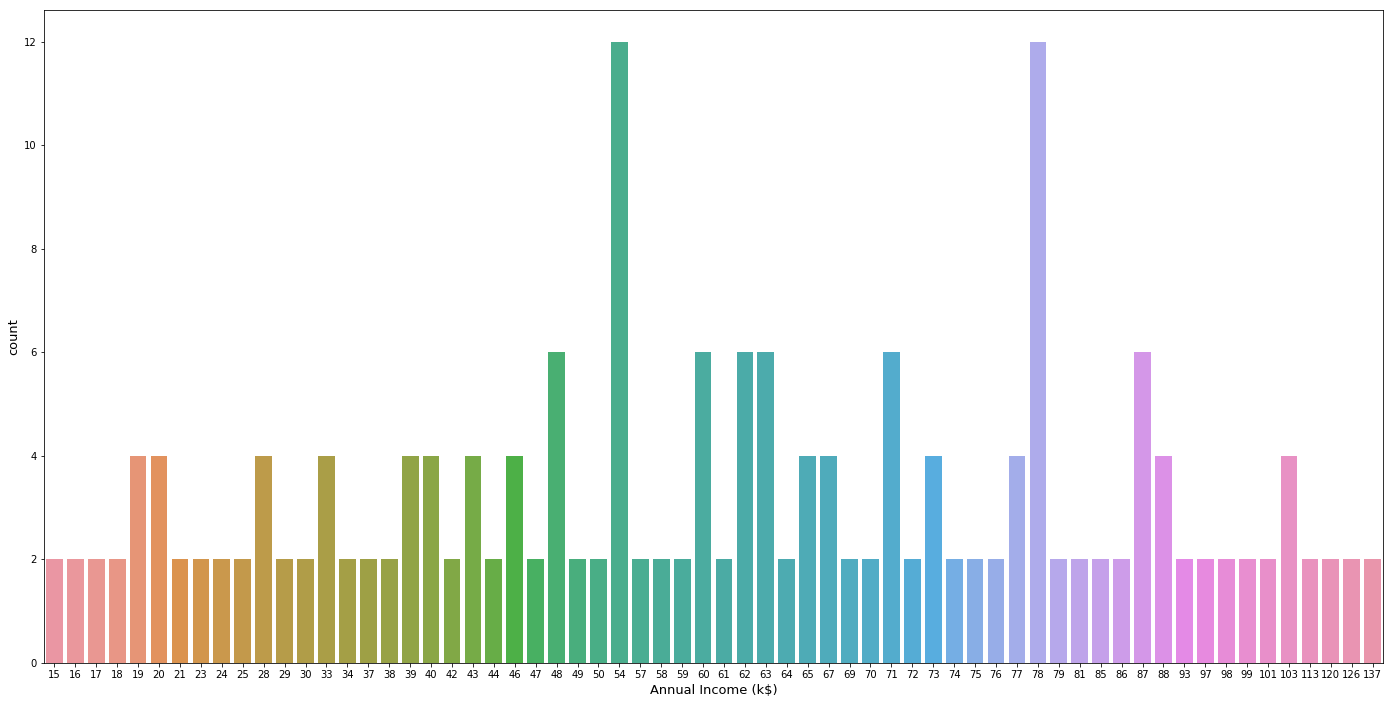

In [30]:
plt.figure(figsize=(24,12))
ax= sns.countplot(x='Annual Income (k$)', data=df.toPandas())
plt.xlabel("Annual Income (k$)", fontsize = 13)
plt.ylabel("count", fontsize = 13)
plt.show()

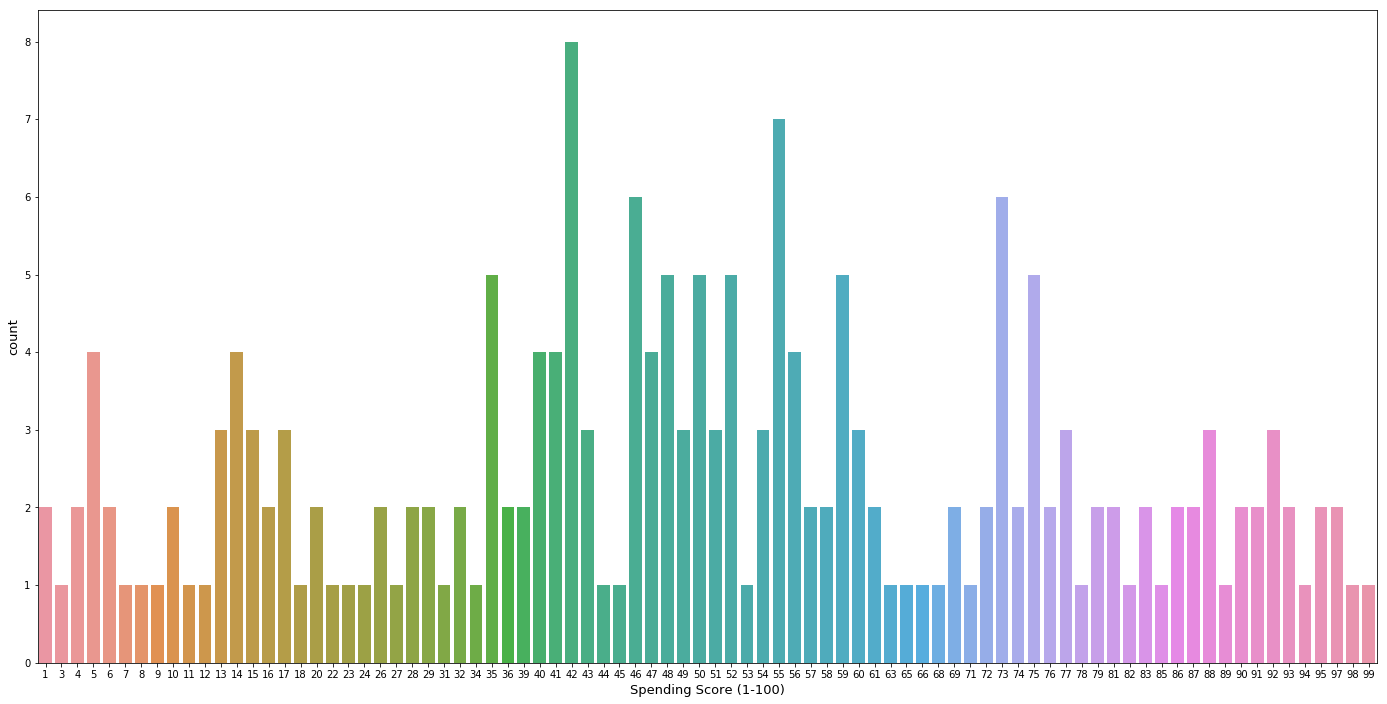

In [31]:
plt.figure(figsize=(24,12))
ax= sns.countplot(x='Spending Score (1-100)', data=df.toPandas())
plt.xlabel("Spending Score (1-100)", fontsize = 13)
plt.ylabel("count", fontsize = 13)
plt.show()

In [32]:
from pyspark.ml.feature import VectorAssembler


In [35]:
assembler = VectorAssembler(inputCols= [ 'Annual Income (k$)', 'Spending Score (1-100)'],
                           outputCol='features')
#Input columns will convert into DenseVector
df = assembler.transform(df)

In [38]:
df.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Annual Income (k$): integer (nullable = true)
 |-- Spending Score (1-100): integer (nullable = true)
 |-- features: vector (nullable = true)



In [37]:
# as the range for the features is the same, we dn't need to apply feature pre-processing (scaling)

In [39]:
df.select('features').show(truncate=False)

+-----------+
|features   |
+-----------+
|[15.0,39.0]|
|[15.0,81.0]|
|[16.0,6.0] |
|[16.0,77.0]|
|[17.0,40.0]|
|[17.0,76.0]|
|[18.0,6.0] |
|[18.0,94.0]|
|[19.0,3.0] |
|[19.0,72.0]|
|[19.0,14.0]|
|[19.0,99.0]|
|[20.0,15.0]|
|[20.0,77.0]|
|[20.0,13.0]|
|[20.0,79.0]|
|[21.0,35.0]|
|[21.0,66.0]|
|[23.0,29.0]|
|[23.0,98.0]|
+-----------+
only showing top 20 rows



In [40]:
train, test = df.randomSplit([.85,.15], seed=13)

In [ ]:
# Elbow method

In [42]:
from pyspark.ml.clustering import KMeans

In [64]:
# Within-Cluster-Sum-of-Squares
wcss = np.zeros(21)

for k in range(2, 21):
    kmeans = KMeans().setK(k)\
            .setSeed(k**2)\
            .setFeaturesCol('features')\
            .setPredictionCol('cluster')\
            .setMaxIter(100)
    #model = kmeans.fit(train)
    model = kmeans.fit(df)
    #wcss[k] = model.computeCost(train)
    wcss[k] = model.computeCost(df)

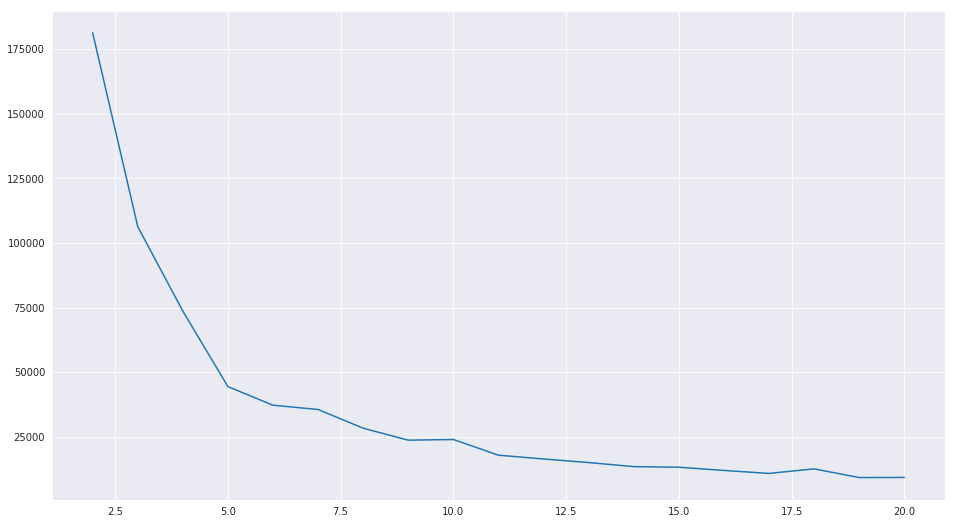

In [65]:
sns.set_style('darkgrid')
ax=plt.figure(figsize=(16,9))
plt.plot(range(2,21), wcss[2:21])

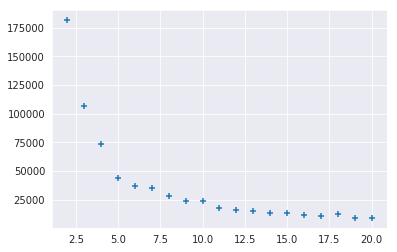

In [66]:
plt.scatter(range(2,21), wcss[2:21], marker='+')
plt.xlabel=('k')
plt.ylabel=('WCSS')
plt.show()

In [56]:
# From elbow method optimum number of k == 5

In [67]:
kmeans = KMeans().setK(5)\
        .setSeed(1)\
        .setFeaturesCol('features')\
        .setPredictionCol('cluster')\
        .setMaxIter(100)

model = kmeans.fit(train)

wcss = model.computeCost(train)

print(wcss)

57323.05775862046


In [68]:
print(model.computeCost(test))

10435.44281699069


In [69]:
# provides predicted clusters for test samples
predict_cluster = model.transform(test)
predict_cluster_train = model.transform(train)

In [70]:
predict_cluster.groupby('cluster').count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1|   13|
|      3|    9|
|      4|    1|
|      2|    2|
|      0|    2|
+-------+-----+



In [71]:
predict_cluster_train.groupby('cluster').count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1|   88|
|      3|   29|
|      4|    3|
|      2|   33|
|      0|   20|
+-------+-----+



In [72]:
"""

Me (to Organizer(s) Only):

1:20 PM: in this example since we have two features, k-means is checking distance in 2-dimensional space...? so if we have n features, k-means is checking distance in n-dimensional space?


Amit:

sq(x1 -x1mean) + sq(x2 - x2mean)...

euclidean distance formula:
    sqrt( (x1-x1mean)**2 + (x2-x2mean)**2 + (xn-xnmean)**2 ... )
    x1mean, x2mean --> centroids
"""

'\n\nMe (to Organizer(s) Only):\n\n1:20 PM: in this example since we have two features, k-means is checking distance in 2-dimensional space...? so if we have n features, k-means is checking distance in n-dimensional space?\n\n\nAmit:\n'